# Cut-edges possibilities
This notebook summarizes the possible ways in which we create cut-edges. 

In [1]:
import spot
import buddy
spot.setup()

seminator_path = '../seminator'
def seminator(filename, opt = ''):
    a = spot.automaton(f'{seminator_path} {opt} -s0 {filename} |')
    display(a)
    return a

## Cut-on-SCC-entry
Everytime we have an edge that freshly enters an accepting SCC, we create a cut-edge.

We first create an example automaton using HOA.

In [2]:
%%file cut-on-scc-entry.hoa
HOA: v1
States: 3
Start: 0
AP: 1 "a"
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels trans-acc
--BODY--
State: 0
[0] 0
[!0] 1
[0] 2
State: 1
[!0] 1
[0] 0 {0}
State: 2
[0] 2 {0}
--END--


Overwriting cut-on-scc-entry.hoa


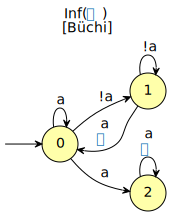

In [3]:
a = spot.automaton('cut-on-scc-entry.hoa'); a

### The default output of Seminator
Cannot be further simplified

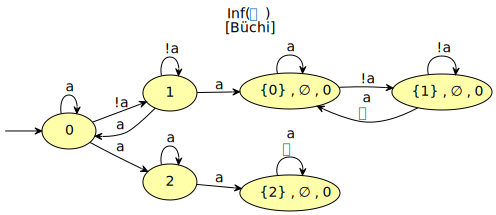

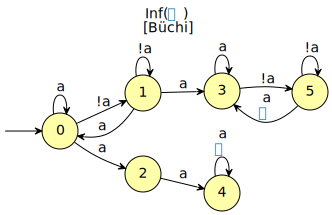

In [4]:
sem = seminator('cut-on-scc-entry.hoa')
sem.postprocess()

In the next we add a transition to the result of Seminator and it will reduce the states after simplifications. For the transition $t=$ 0->2 of the input automaton we add additional cut transition as if $t$ would be accepting.

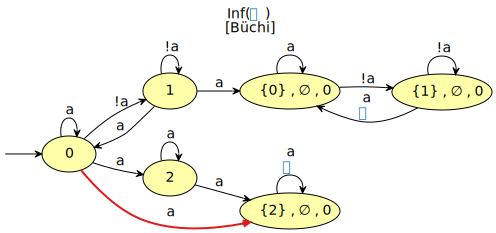

In [5]:
a_ap = buddy.bdd_ithvar(sem.register_ap('a'))
sem.new_edge(0,4,a_ap)
sem.highlight_edge(14,5)

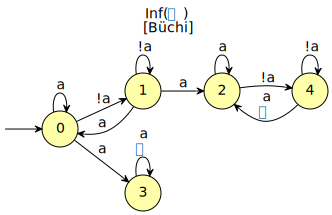

In [6]:
sem.postprocess()

### Test implementation

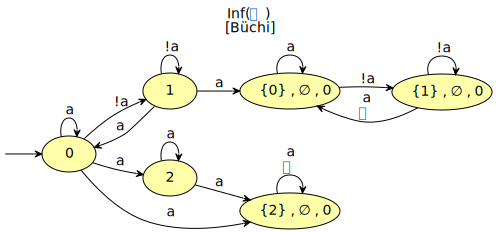

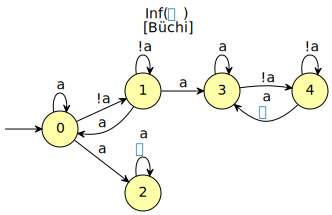

In [7]:
seminator('cut-on-scc-entry.hoa','--cut-on-SCC-entry').postprocess()

## powerset-on-cut
We build cut-edges for edges in the original automaton based on *cut-condition*. For an edge $e=(s,\alpha,p)$ that satisfies the cut-condition we build a cut-edge $\big(s,\alpha,({p},\emptyset,0)\big)$. The option `powerset-on-cut` changes the behaviour such that for $e$ we build rather the cut-edge $$ (s,\alpha,(R,B,0)) \qquad R = \delta(s,\alpha) \qquad B = \delta_0(s,\alpha)$$ where $\delta_0$ computes the successors reachable via edges marked by $0$. The idea is illustrated by the following example which is a case where it saves the state of the form $({p},\emptyset,0)$.

In [8]:
%%file powerset-on-cut.hoa
HOA: v1
States: 2
Start: 0
AP: 1 "a"
Alias: @a 0
Alias: @b !0
Acceptance: 2 Inf(0) & Inf(1)
--BODY--
State: 0
[@a] 0 {0}
[@a] 1 
[@b] 0
State: 1
[@b] 1 {1}
[@b] 0 
[@a] 1
--END--


Writing powerset-on-cut.hoa


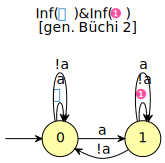

In [9]:
a = spot.automaton('powerset-on-cut.hoa'); a

The default behaviour of seminator creates a 7-state automaton which cannot be reduced by Spot.

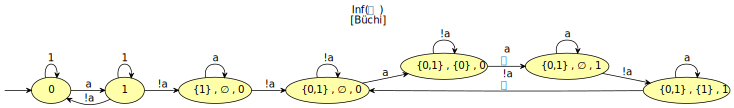

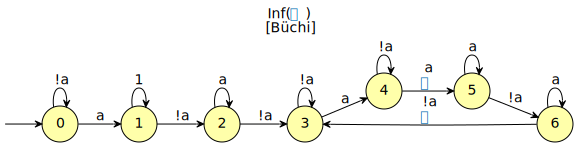

In [10]:
basic = seminator('powerset-on-cut.hoa')
basic.postprocess()

The orange state below will be avoided by the proposed change. The target states of cut-edges always hold exactly 1 state and this state is the same as the source of the red cut-edge. The powerset-successor of the state is thus always computed and reached anyway, now from the breakpoint state. The proposed idea substitutes the red edge by the green edge which makes the orange state unreachable.

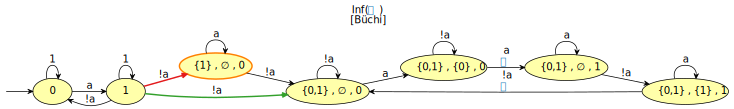

In [11]:
basic.new_edge(1,3,-a_ap)
basic.highlight_state(2,2).highlight_edge(5,5).highlight_edge(16,4)

### Test implementation

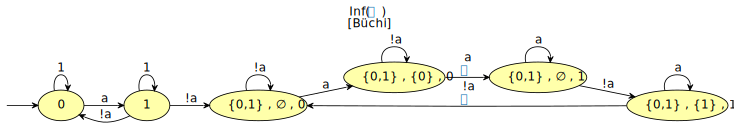

In [12]:
seminator('powerset-on-cut.hoa','--powerset-on-cut');

### Prepare test

In [13]:
option = 'powerset-on-cut'
res = !{seminator_path} -s0 --{option} {option}.hoa
result = "\n".join(res)
testfile = f"../tests/{option}.test"
test = f'''#!/bin/bash
set -e

cat >{option}.hoa <<EOF
{a.to_str()}
EOF

cat >{option}.expect <<EOF
{result}
EOF

../seminator -s0 --{option} {option}.hoa > {option}.out
cat {option}.out
diff {option}.out {option}.expect

rm {option}.out {option}.hoa {option}.expect
'''

In [14]:
print(test,file=open(testfile,'w'))
!chmod +x {testfile}

In [15]:
!{testfile}

HOA: v1
States: 6
Start: 0
AP: 1 "a"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels trans-acc complete
properties: semi-deterministic
--BODY--
State: 0 "0"
[t] 0
[0] 1
State: 1 "1"
[!0] 0
[t] 1
[!0] 2
State: 2 "{0,1} , ∅ , 0"
[!0] 2
[0] 3
State: 3 "{0,1} , {0} , 0"
[!0] 3
[0] 4 {0}
State: 4 "{0,1} , ∅ , 1"
[0] 4
[!0] 5
State: 5 "{0,1} , {1} , 1"
[!0] 2 {0}
[0] 5
--END--
